In [1]:
import os
os.getcwd()

'/content'

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!ln -s /content/gdrive/My\ Drive/ /mydrive

In [4]:
!cp /mydrive/Yolov3/img.zip ./

In [5]:
!unzip ./img.zip -d ./img

Streaming output truncated to the last 5000 lines.
  inflating: ./img/img/hard_hat_workers3248.txt  
  inflating: ./img/img/hard_hat_workers3249.png  
  inflating: ./img/img/hard_hat_workers3249.txt  
  inflating: ./img/img/hard_hat_workers325.png  
  inflating: ./img/img/hard_hat_workers325.txt  
  inflating: ./img/img/hard_hat_workers3250.png  
  inflating: ./img/img/hard_hat_workers3250.txt  
  inflating: ./img/img/hard_hat_workers3251.png  
  inflating: ./img/img/hard_hat_workers3251.txt  
  inflating: ./img/img/hard_hat_workers3252.png  
  inflating: ./img/img/hard_hat_workers3252.txt  
  inflating: ./img/img/hard_hat_workers3253.png  
  inflating: ./img/img/hard_hat_workers3253.txt  
  inflating: ./img/img/hard_hat_workers3254.png  
  inflating: ./img/img/hard_hat_workers3254.txt  
  inflating: ./img/img/hard_hat_workers3255.png  
  inflating: ./img/img/hard_hat_workers3255.txt  
  inflating: ./img/img/hard_hat_workers3256.png  
  inflating: ./img/img/hard_hat_workers3256.txt  
 

In [6]:
import glob
import numpy as np

images = glob.glob("./img/img/*.png")
images_path = np.array(sorted(images))[0:250]
images_path

array(['./img/img/hard_hat_workers0.png',
       './img/img/hard_hat_workers1.png',
       './img/img/hard_hat_workers10.png',
       './img/img/hard_hat_workers100.png',
       './img/img/hard_hat_workers1000.png',
       './img/img/hard_hat_workers1001.png',
       './img/img/hard_hat_workers1002.png',
       './img/img/hard_hat_workers1003.png',
       './img/img/hard_hat_workers1004.png',
       './img/img/hard_hat_workers1005.png',
       './img/img/hard_hat_workers1006.png',
       './img/img/hard_hat_workers1007.png',
       './img/img/hard_hat_workers1008.png',
       './img/img/hard_hat_workers1009.png',
       './img/img/hard_hat_workers101.png',
       './img/img/hard_hat_workers1010.png',
       './img/img/hard_hat_workers1011.png',
       './img/img/hard_hat_workers1012.png',
       './img/img/hard_hat_workers1013.png',
       './img/img/hard_hat_workers1014.png',
       './img/img/hard_hat_workers1015.png',
       './img/img/hard_hat_workers1016.png',
       './img/img/ha

In [7]:
txtfiles = glob.glob("./img/img/*.txt")
txtfiles_path = np.array(sorted(txtfiles))[0:250]
txtfiles_path

array(['./img/img/hard_hat_workers0.txt',
       './img/img/hard_hat_workers1.txt',
       './img/img/hard_hat_workers10.txt',
       './img/img/hard_hat_workers100.txt',
       './img/img/hard_hat_workers1000.txt',
       './img/img/hard_hat_workers1001.txt',
       './img/img/hard_hat_workers1002.txt',
       './img/img/hard_hat_workers1003.txt',
       './img/img/hard_hat_workers1004.txt',
       './img/img/hard_hat_workers1005.txt',
       './img/img/hard_hat_workers1006.txt',
       './img/img/hard_hat_workers1007.txt',
       './img/img/hard_hat_workers1008.txt',
       './img/img/hard_hat_workers1009.txt',
       './img/img/hard_hat_workers101.txt',
       './img/img/hard_hat_workers1010.txt',
       './img/img/hard_hat_workers1011.txt',
       './img/img/hard_hat_workers1012.txt',
       './img/img/hard_hat_workers1013.txt',
       './img/img/hard_hat_workers1014.txt',
       './img/img/hard_hat_workers1015.txt',
       './img/img/hard_hat_workers1016.txt',
       './img/img/ha

In [8]:
imagefolder = "./img/img"
image_size = 415
image_labels = ["head","person","helmet"]

In [9]:
import torch
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, transforms
from PIL import Image
from xml.dom.minidom import parse


In [10]:
import glob
import numpy

class ImagesWithTxtDataset(torch.utils.data.Dataset):
    
    def __init__(self, folder,transforms=None):
        self.folder = folder
        self.images = np.array(list(sorted(glob.glob(f"{folder}/*.png"))))[0:250]
        self.txt_annotations = np.array(list(sorted(glob.glob(f"{folder}/*.txt"))))[0:250]
        self.transforms = transforms
        
        
    def __getitem__(self, idx):

        # get image PIL format
        img_name = self.images[idx]
        img_path = img_name
        img = Image.open(img_path).convert("RGB") 


        # get txt info
        txt_name = self.txt_annotations[idx]
        txt_path = txt_name
        file = open(txt_path,"r")

        boxes = []
        labels = []
        crowd_len = 0

        for line in file.readlines():
            crowd_len +=1

            # real image size will be replaced with image_size
            words = line.split(" ")
            class_num = (int(words[0])+1)
            x_min = np.float(words[1])*image_size
            y_min = np.float(words[2])*image_size
            width = np.float(words[3])*image_size
            height = np.float(words[4])*image_size

            x_max = x_min + width
            y_max = y_min + height
            
            a = [x_min,y_min,x_max,y_max]

            boxes.append(a)
            
            labels.append(class_num)
        
        boxes = np.array(boxes)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.as_tensor(labels, dtype=torch.int64)      
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((crowd_len,), dtype=torch.int64)

        target = {
        }
        target['boxes'] = boxes
        target['labels'] = labels
        target['area'] = area
        target['iscrowd'] = iscrowd
        
        
        if self.transforms is not None:
            img = self.transforms(img)
           
       
        
        return img,target
        
    
    def __len__(self):
        return len(self.images)

In [11]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
 
      
def get_object_detection_model(num_classes):
    # load an object detection model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # Add one to num_classes as a index assigned for nothing
    num_classes = num_classes+1
 
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
 
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
    return model

In [12]:
model = get_object_detection_model((len(image_labels)))
model.roi_heads

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign()
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=4, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=16, bias=True)
  )
)

In [13]:
data_transforms = transforms.Compose([transforms.Resize((image_size,image_size)),transforms.ToTensor()])

dataset = ImagesWithTxtDataset(imagefolder,data_transforms)

In [14]:
#Check to see if it is working well
for i in range(len(dataset)):
    #print(dataset[i])
    break

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

In [16]:
def collate_fn(batch):
    return tuple(zip(*batch))

data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=8, shuffle=True,collate_fn=collate_fn)

In [17]:
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

In [18]:
params = [p for p in model.parameters() if p.requires_grad]

# SGD
optimizer = torch.optim.SGD(params, lr=0.0003,
                            momentum=0.9, weight_decay=0.0005)
num_epochs = 15

lr_scheduler = None

In [19]:
loss_hist = []
itr = 0

for epoch in range(num_epochs):
    
    loss_epoch = []
    for images, targets in data_loader:
           
        
    
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        
       
        
        loss_dict = model(images, targets)
        
       
        
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        if itr % 10 == 0:
            print("loss_value",loss_value)
        itr+=1
        
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loss_epoch.append(loss_value)
        
        
    loss_mean = sum(loss_epoch) / len(loss_epoch)
    loss_hist.append(loss_mean)
    print(f"loss value {loss_mean} on epoch [{epoch}]")
    
  

    #print(f"Epoch #{epoch} loss: {loss_hist.value}")

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


loss_value 1.7791526317596436
loss_value 0.5424652695655823
loss_value 0.5702334046363831
loss_value 0.5525220632553101
loss value 0.8546298304572701 on epoch [0]
loss_value 0.532529890537262
loss_value 0.6042574644088745
loss_value 0.5989074110984802
loss value 0.6630575079470873 on epoch [1]
loss_value 0.4793679118156433
loss_value 0.8548589944839478
loss_value 0.7183764576911926
loss value 0.6968203643336892 on epoch [2]
loss_value 0.41357919573783875
loss_value 0.986947774887085
loss_value 0.7415797114372253
loss value 0.7244826117530465 on epoch [3]


KeyboardInterrupt: ignored

In [145]:
sample_img = "hard_hat_workers0.png"
sample_path1 = imagefolder + "/" + sample_img



def predict(model,image,threshold):
  model.eval()
  transform = transforms.Compose([
    transforms.Resize((image_size,image_size)),
    transforms.ToTensor()
    
  ])

  image = transform(image).to(device)
  image = image.unsqueeze(0) # add a batch dimension

  outputs = model(image)
  
  


  # 0 represent nothing, so index starts at 0
  # returns class name and class index as array of tuples
  predict_classes = outputs[0]['labels'].cpu().numpy()

  # get score for all the predicted objects
  #scores are sorted by order, so first n boxes are important for us
  predict_scores = outputs[0]['scores'].detach().cpu().numpy()
    # get all the predicted bounding boxes
  boxes = outputs[0]['boxes'].detach().cpu().numpy()
  
  scores_bigger_than_threshold = predict_scores >= threshold
  predict_boxes = boxes[scores_bigger_than_threshold].astype(np.int32)
  

  return image[0], predict_boxes, predict_classes[:len(predict_boxes)], predict_scores[:len(predict_boxes)]

img = Image.open(sample_path1).convert("RGB") 
image, boxes, classes, scores = predict(model,img, 0.25)
boxes,classes, scores




(array([[329, 164, 360, 198],
        [130, 163, 148, 187],
        [184, 170, 202, 192],
        [264, 153, 290, 200],
        [205, 158, 225, 179],
        [333, 158, 351, 177],
        [324, 154, 357, 189],
        [376, 140, 413, 175],
        [228, 165, 245, 189],
        [336, 161, 356, 182],
        [268, 167, 288, 189],
        [372, 136, 415, 215],
        [204, 157, 233, 189],
        [ 65, 157,  92, 188],
        [ 33, 164,  49, 196],
        [127, 169, 147, 193],
        [ 12, 161,  47, 201]], dtype=int32),
 array([3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]),
 array([0.33156344, 0.31364965, 0.2987406 , 0.2956258 , 0.2892065 ,
        0.28784725, 0.27639902, 0.27553222, 0.27479345, 0.27310878,
        0.26551443, 0.26201028, 0.25916624, 0.25832826, 0.25554642,
        0.25468543, 0.25053734], dtype=float32))

In [146]:
def nms(bounding_boxes, confidence_score, labels, threshold):
    # If no bounding boxes, return empty list
    if len(bounding_boxes) == 0:
        return []


    # Bounding boxes
    boxes = np.array(bounding_boxes)

    # Confidence scores of bounding boxes
    score = np.array(confidence_score)

    # labels
    labels = np.array(labels)

    
    # Picked bounding boxes
    picked_boxes = []
    picked_score = []
    picked_labels = []

    unique_labels = np.unique(labels)

    mask = [labels == i for i in unique_labels]

    iterator = 0

    for m in mask:
      
      sub_boxes = boxes[m]
      sub_score = score[m]

     

      # coordinates of bounding boxes
      start_x = sub_boxes[:, 0]
      start_y = sub_boxes[:, 1]
      end_x = sub_boxes[:, 2]
      end_y = sub_boxes[:, 3]

      


      # Compute areas of bounding boxes
      areas = (end_x - start_x + 1) * (end_y - start_y + 1)
    

      # Sort by confidence score of bounding boxes
      order = np.argsort(sub_score)
      

      # Iterate bounding boxes
      while order.size > 0:
          # The index of largest confidence score
          index = order[-1]

        

          # Pick the bounding box with largest confidence score
          picked_boxes.append(sub_boxes[index])
          picked_score.append(sub_score[index])
          picked_labels.append(unique_labels[iterator])

          

          # Compute ordinates of intersection-over-union(IOU)
          #x1 returns max of n-1 x1 as it brodcast find max one by one
          x1 = np.maximum(start_x[index], start_x[order[:-1]])
          x2 = np.minimum(end_x[index], end_x[order[:-1]])
          y1 = np.maximum(start_y[index], start_y[order[:-1]])
          y2 = np.minimum(end_y[index], end_y[order[:-1]])

          # Compute areas of intersection-over-union
          w = np.maximum(0.0, x2 - x1 + 1)
          h = np.maximum(0.0, y2 - y1 + 1)
          intersection = w * h

          

          # Compute the ratio between intersection and union
          ratio = intersection / (areas[index] + areas[order[:-1]] - intersection)

          left = np.where(ratio < threshold)

          # continue with those who are not so close to main frame.
          order = order[left]
      
      # color loop
      iterator+=1

    return picked_boxes, picked_score, picked_labels



In [147]:
picked_boxes, picked_score, picked_labels = nms(boxes,scores,classes,0.4)
picked_boxes, picked_score,picked_labels

([array([329, 164, 360, 198], dtype=int32),
  array([130, 163, 148, 187], dtype=int32),
  array([184, 170, 202, 192], dtype=int32),
  array([264, 153, 290, 200], dtype=int32),
  array([205, 158, 225, 179], dtype=int32),
  array([333, 158, 351, 177], dtype=int32),
  array([376, 140, 413, 175], dtype=int32),
  array([228, 165, 245, 189], dtype=int32),
  array([268, 167, 288, 189], dtype=int32),
  array([372, 136, 415, 215], dtype=int32),
  array([ 65, 157,  92, 188], dtype=int32),
  array([ 33, 164,  49, 196], dtype=int32),
  array([ 12, 161,  47, 201], dtype=int32)],
 [0.33156344,
  0.31364965,
  0.2987406,
  0.2956258,
  0.2892065,
  0.28784725,
  0.27553222,
  0.27479345,
  0.26551443,
  0.26201028,
  0.25832826,
  0.25554642,
  0.25053734],
 [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3])

In [148]:
# as image labels starts from 1, added 1 to compensate
COLORS = np.random.uniform(0, 255, size=(len(image_labels)+1, 3))

def draw_bounding_box(image,bounding_boxes,confidence_score,label):


  open_cv_image = numpy.array(image) 
  # Convert RGB to BGR 
  image = open_cv_image[:, :, ::-1].copy() 

  print("image shape : ",image.shape)

  # Draw parameters
  font = cv2.FONT_HERSHEY_SIMPLEX
  font_scale = 0.3
  thickness = 1
  
  for index,((start_x, start_y, end_x, end_y), confidence) in enumerate(zip(bounding_boxes, confidence_score)):

      print("confidence : ",confidence," rectangle :",(start_x,start_y)," ",(end_x, end_y))
      (w, h), baseline = cv2.getTextSize(str(image_labels[label[index]-1]), font, font_scale, thickness)
      cv2.rectangle(image, (start_x, start_y - (2 * baseline + 5)), (start_x + w, start_y), (22,93,0), -1)
      
      cv2.rectangle(image, (start_x, start_y), (end_x, end_y), COLORS[label[index]], 2)
    
      cv2.putText(image, str(image_labels[label[index]-1]), (start_x, start_y), font, font_scale, (0, 0, 0), thickness)
  
  return image



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


image shape :  (415, 415, 3)
confidence :  0.33156344  rectangle : (329, 164)   (360, 198)
confidence :  0.31364965  rectangle : (130, 163)   (148, 187)
confidence :  0.2987406  rectangle : (184, 170)   (202, 192)
confidence :  0.2956258  rectangle : (264, 153)   (290, 200)
confidence :  0.2892065  rectangle : (205, 158)   (225, 179)
confidence :  0.28784725  rectangle : (333, 158)   (351, 177)
confidence :  0.27553222  rectangle : (376, 140)   (413, 175)
confidence :  0.27479345  rectangle : (228, 165)   (245, 189)
confidence :  0.26551443  rectangle : (268, 167)   (288, 189)
confidence :  0.26201028  rectangle : (372, 136)   (415, 215)
confidence :  0.25832826  rectangle : (65, 157)   (92, 188)
confidence :  0.25554642  rectangle : (33, 164)   (49, 196)
confidence :  0.25053734  rectangle : (12, 161)   (47, 201)


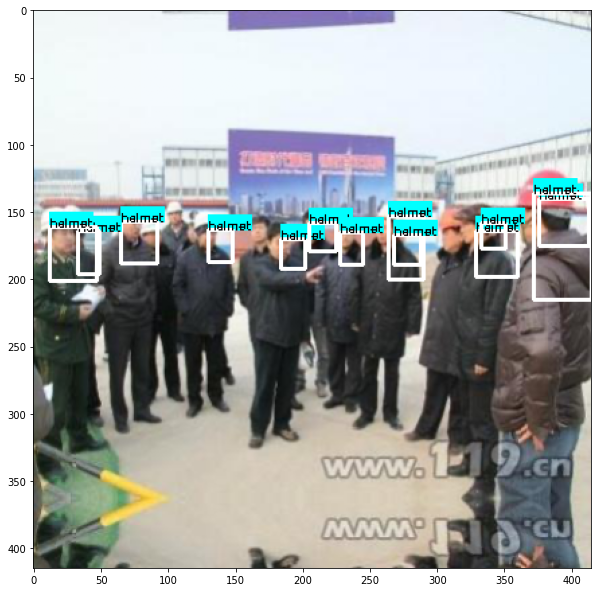

In [149]:
# used image for prediction.
np_predicted_image = image.to("cpu").numpy().transpose((1,2,0))
final_cv2_image = draw_bounding_box(np_predicted_image,picked_boxes, picked_score,picked_labels)

final_plt_image = cv2.cvtColor(final_cv2_image,cv2.COLOR_BGR2RGB)

from pylab import rcParams
rcParams['figure.figsize'] = 10, 20
plt.imshow(final_plt_image)

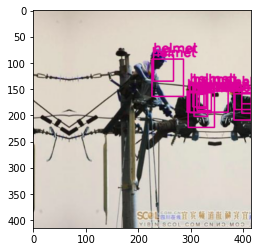

In [ ]:
plt.imshow(result_image)